# 03 - Listing-Level Demand Forecasting (Spark MLlib, PyTorch, Tensorflow Keras / Big-Data Strategy)

This notebook trains **listing-level demand models** directly in Spark using the engineered dataset from Notebook 02.

**Data source (single source of truth):**
- `data/processed/listing_features.parquet` (includes `elasticity_slope` already added in Notebook 02)

**Goal:** predict **booking demand** (`occupancy_rate`) using listing + pricing + market context features (including `elasticity_slope`).

**Approach (Spark-native):**
- Load Parquet into a Spark DataFrame (no pandas conversion)
- Build a Spark MLlib pipeline: type cleaning → imputation → vector assembly → model
- Train and evaluate multiple regressors (baseline + tree models)
- Train and evaluate PyTorch Model
- Train and evaluate TensorFlow Keras model
- Compare the best model and feature importances (where supported)

**Outputs**
- `outputs/spark_model_results.csv`
- `outputs/spark_feature_importance.csv` (tree models)
- `models/spark_MLlib_model/` (Spark MLlib pipeline model)
- `models/airbnb_keras_model.keras`
- `models/airbnb_pytorch_model.pth`

In [1]:
%load_ext autoreload
%autoreload 2

## Load PySpark and Data

In [2]:
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd

# Locate project root (folder containing 'src')
project_root = Path.cwd()
for p in [project_root] + list(project_root.parents):
    if (p / 'src').exists():
        project_root = p
        break
if not (project_root / 'src').exists():
    raise FileNotFoundError("Could not find 'src' directory.")

# Windows Spark/Hadoop helpers (assumes hadoop binaries already exist from Notebook 01)
hadoop_home = project_root / 'hadoop'
bin_dir = hadoop_home / 'bin'
os.environ['HADOOP_HOME'] = str(hadoop_home)
os.environ['hadoop.home.dir'] = str(hadoop_home)
os.environ['PATH'] = str(bin_dir) + os.pathsep + os.environ.get('PATH', '')

sys.path.insert(0, str(project_root))

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.storagelevel import StorageLevel

spark = (
    SparkSession.builder
    .appName('airbnb-demand-forecasting-sparkml')
    .master('local[*]')
    # Stability / memory headroom for ML on Windows
    .config('spark.driver.memory', '4g')
    .config('spark.sql.shuffle.partitions', '32')
    .config('spark.default.parallelism', '32')
    .config('spark.driver.maxResultSize', '1g')
    .config('spark.sql.crossJoin.enabled', 'true')
    .config("spark.sql.execution.arrow.pyspark.enabled", "false")
    .getOrCreate()
 )

# Clear cache before training
spark.catalog.clearCache()

print('Spark version:', spark.version)
np.random.seed(42)

Spark version: 3.5.0


In [3]:
# Persist datasets (Spark writes)
out_processed = project_root / 'data' / 'processed'
out_processed.mkdir(parents=True, exist_ok=True)
outputs_dir = project_root / 'outputs'
outputs_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Verify listing features file exists
listing_features_file = out_processed / 'listing_features.parquet'
print(f"Listing features path: data/processed/listing_features.parquet")

if listing_features_file.exists():
    print(f"File exists: {listing_features_file.exists()}")
else:
    print("File not found. Run Notebook 02 to generate listing_features.parquet")

Listing features path: data/processed/listing_features.parquet
File exists: True


In [5]:
# Load listing-level engineered features (Spark-only)
listing_features_path = str(out_processed / 'listing_features.parquet')
if not Path(listing_features_path).exists():
    raise FileNotFoundError(f"Missing {listing_features_path}. Run Notebook 02 first.")

# Load single-file parquet
df = spark.read.parquet(listing_features_path)

# Check row count immediately
row_count = df.count()
print(f"Loaded listing_features.parquet: {row_count:,} rows")
print(f"Columns: {len(df.columns)}")

# Only persist verification to avoid duplicate reads
df = df.persist(StorageLevel.MEMORY_AND_DISK)

# Quick sanity checks
sample_cols = ['listing_price', 'price_per_bedroom', 'quality_score', 'elasticity_slope', 'occupancy_rate']
missing = [c for c in sample_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in parquet: {missing}")

df.select(sample_cols).summary().show(truncate=False)

Loaded listing_features.parquet: 305,252 rows
Columns: 53
+-------+------------------+------------------+------------------+-------------------+-------------------+
|summary|listing_price     |price_per_bedroom |quality_score     |elasticity_slope   |occupancy_rate     |
+-------+------------------+------------------+------------------+-------------------+-------------------+
|count  |305252            |305252            |305252            |305252             |305252             |
|mean   |99.98332167488543 |82.05545660716199 |57.89984006088306 |-0.58349372971844  |0.6087287842089295 |
|stddev |53.200284294250835|37.79923324687365 |7.81245116158577  |0.3458564685287296 |0.23247886438179075|
|min    |23.869886128024927|2.983735766003116 |10.6              |-1.2201693432675256|0.05               |
|25%    |56.52006443725251 |53.09657790340092 |52.727322428795944|-0.8456471640695179|0.4259311203526758 |
|50%    |89.26350320480043 |74.27663089648242 |58.624755889033466|-0.6609335075252749|

## Prepare Data for Training

In [6]:
# Basic cleaning: ensure label is double, and keep only usable feature columns
from pyspark.sql.types import (
    StringType, BooleanType, NumericType
 )

target_col = 'occupancy_rate'
label_col = 'label'

df2 = df.withColumn(label_col, F.col(target_col).cast('double'))

# Cast booleans to ints (Spark ML prefers numeric features)
for field in df2.schema.fields:
    if isinstance(field.dataType, BooleanType):
        df2 = df2.withColumn(field.name, F.col(field.name).cast('int'))

# Drop redundant columns if they exist
_redundant = [
    'city', 
    'weekend', 
    'season', 
    'room_shared', 
    'room_private', 
    'log_bookings', 
    'listing_id',
    'days_in_period',
    'days_booked',
    'segment_listing_count',
]
_to_drop = [c for c in _redundant if c in df2.columns]
if _to_drop:
    df2 = df2.drop(*_to_drop)
    print(f"Dropped columns: {_to_drop}")

# Drop rows with null label
df2 = df2.filter(F.col(label_col).isNotNull())

print('Rows after label cleaning (lazy):')
df2.select(F.count('*').alias('rows')).show()

Dropped columns: ['listing_id', 'days_in_period', 'days_booked', 'segment_listing_count']
Rows after label cleaning (lazy):
+------+
|  rows|
+------+
|305252|
+------+



### Standarize numeric columns

We should always standardize numeric features for NNs (and Linear Regression), although it's not necessary for tree-based models

In [8]:
# Build a Spark ML pipeline (scales numeric + skips binary cols)
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark import StorageLevel

# Columns to exclude from features
target_col = 'occupancy_rate'
label_col = 'label'
exclude_cols = {target_col, label_col}

# Define feature groups
numeric_features = [
    'listing_price', 'person_capacity', 'cleanliness_rating',
    'guest_satisfaction_overall', 'bedrooms', 'city_center_dist',
    'metro_dist', 'log_price', 'price_per_person', 'price_per_bedroom',
    'quality_score', 'price_x_satisfaction', 'price_per_dist_km',
    'log_metro_dist', 'segment_avg_price', 'segment_median_price', 
    'segment_p90_price', 'segment_p10_price', 'segment_price_std', 
    'segment_price_spread', 'price_vs_segment_median', 'price_vs_segment_avg', 
    'relative_price_volatility', 'elasticity_slope',
]

binary_features = [
    'host_is_superhost', 'multi', 'biz', 'cat_room_type_entire_home_apt', 
    'cat_room_type_private_room', 'cat_room_type_shared_room', 'cat_city_amsterdam',
    'cat_city_athens', 'cat_city_barcelona', 'cat_city_berlin', 'cat_city_budapest',
    'cat_city_lisbon', 'cat_city_london', 'cat_city_paris', 'cat_city_rome', 
    'cat_city_vienna', 'is_weekend', 'cat_capacity_bin_2', 'cat_capacity_bin_3',
    'cat_capacity_bin_4', 'cat_capacity_bin_5', 'cat_season_high', 'cat_season_low',
    'cat_season_shoulder',
]

print(f"Numeric features: {len(numeric_features)}")
print(f"Binary features: {len(binary_features)}")

# Split data
train_df, test_df = df2.randomSplit([0.8, 0.2], seed=42)
train_df = train_df.persist(StorageLevel.MEMORY_AND_DISK)
test_df = test_df.persist(StorageLevel.MEMORY_AND_DISK)

print(f"\nTrain rows: {train_df.count():,}")
print(f"Test rows:  {test_df.count():,}")

# ============================================================================
# STANDARDIZE NUMERIC FEATURES (fit on train only, apply to both)
# ============================================================================

# Step 1: Assemble numeric features into vector
numeric_assembler = VectorAssembler(
    inputCols=numeric_features,
    outputCol='numeric_features_raw',
    handleInvalid='keep'
)

# Step 2: Standardize the numeric vector
numeric_scaler = StandardScaler(
    inputCol='numeric_features_raw',
    outputCol='numeric_features_scaled',
    withStd=True,
    withMean=True  # Center the data (safe since no sparse features here)
)

# Step 3: Create pipeline for scaling (fit on train only)
scaling_pipeline = Pipeline(stages=[numeric_assembler, numeric_scaler])

# Fit pipeline on TRAIN data only (prevents leakage)
print("\nFitting scaler on training data only...")
scaling_model = scaling_pipeline.fit(train_df)

# Transform both train and test using the SAME fitted scaler
print("Applying scaling to train and test...")
train_df = scaling_model.transform(train_df)
test_df = scaling_model.transform(test_df)

# ============================================================================
# COMBINE SCALED NUMERIC + BINARY FEATURES
# ============================================================================

# Step 4: Combine scaled numeric features with binary features
final_assembler = VectorAssembler(
    inputCols=['numeric_features_scaled'] + binary_features,
    outputCol='features',
    handleInvalid='keep'
)

train_df = final_assembler.transform(train_df)
test_df = final_assembler.transform(test_df)

# Clean up intermediate columns
train_df = train_df.drop('numeric_features_raw')
test_df = test_df.drop('numeric_features_raw')

print(f"\nFinal feature vector size: {len(numeric_features) + len(binary_features)}")
print("  • Numeric features: standardized (mean=0, std=1)")
print("  • Binary features: kept as-is (0 or 1)")

# ============================================================================
# CREATE EVALUATORS
# ============================================================================

evaluator_rmse = RegressionEvaluator(
    labelCol=label_col, 
    predictionCol='prediction', 
    metricName='rmse'
)
evaluator_mae = RegressionEvaluator(
    labelCol=label_col, 
    predictionCol='prediction', 
    metricName='mae'
)
evaluator_r2 = RegressionEvaluator(
    labelCol=label_col, 
    predictionCol='prediction', 
    metricName='r2'
)

print('\nDatasets ready for training')


Numeric features: 24
Binary features: 24

Train rows: 244,392
Test rows:  60,860

Fitting scaler on training data only...
Applying scaling to train and test...

Final feature vector size: 48
  • Numeric features: standardized (mean=0, std=1)
  • Binary features: kept as-is (0 or 1)

Datasets ready for training


## Train Spark MLlib models

In [9]:
# ============================================================================
# CREATE UNSCALED FEATURES FOR TREE MODELS
# ============================================================================
from pyspark.ml.feature import VectorAssembler

print("Creating unscaled features for tree models...")

# Assemble unscaled features (original numeric + binary)
unscaled_assembler = VectorAssembler(
    inputCols=numeric_features + binary_features,
    outputCol='features_unscaled',
    handleInvalid='keep'
)

train_df = unscaled_assembler.transform(train_df)
test_df = unscaled_assembler.transform(test_df)

print(f"Created 'features_unscaled' column with {len(numeric_features + binary_features)} features")

Creating unscaled features for tree models...
Created 'features_unscaled' column with 48 features


In [10]:
# Train and compare Spark MLlib models

models_summary_info = None

def fit_eval(model_name: str, regressor):
    """
    Train model on preprocessed data and evaluate performance.
    Returns trained model and metrics dictionary.
    """
    # Train directly on prepared data
    model = regressor.fit(train_df)
    
    # Make predictions
    preds = model.transform(test_df)
    
    # Evaluate
    rmse = evaluator_rmse.evaluate(preds)
    mae = evaluator_mae.evaluate(preds)
    r2 = evaluator_r2.evaluate(preds)
    
    return model, {
        'model': model_name, 
        'rmse': float(rmse), 
        'mae': float(mae), 
        'r2': float(r2)
    }

# Define models (data already scaled, just train)
candidates = [
    ('LinearRegression', LinearRegression(
        featuresCol='features', # best with scaled features
        labelCol=label_col, 
        regParam=0.0, 
        elasticNetParam=0.0, 
        maxIter=200
    )),
    ('GBTRegressor', GBTRegressor(
        featuresCol='features_unscaled', # best with unscaled features
        labelCol=label_col, 
        maxIter=200, 
        maxDepth=5, 
        stepSize=0.1, 
        subsamplingRate=0.8, 
        seed=42
    )),
    ('RandomForest', RandomForestRegressor(
        featuresCol='features_unscaled', # best with unscaled features
        labelCol=label_col, 
        numTrees=200, 
        maxDepth=8, 
        maxBins=64, 
        subsamplingRate=0.8, 
        featureSubsetStrategy='sqrt', 
        seed=42
    )),
]

# Train all models
print("Training models on scaled data...\n")
results = []
trained = {}

for name, reg in candidates:
    print(f"Training {name}...")
    m, r = fit_eval(name, reg)
    trained[name] = m
    results.append(r)
    print(f"  RMSE={r['rmse']:.4f} | MAE={r['mae']:.4f} | R²={r['r2']:.4f}\n")

# Sort by RMSE
results_sorted = sorted(results, key=lambda x: x['rmse'])

print('='*70)
print('MODEL COMPARISON (sorted by RMSE):')
print('='*70)
for r in results_sorted:
    print(f"{r['model']:20s} | RMSE={r['rmse']:8.4f} | MAE={r['mae']:7.4f} | R²={r['r2']:7.4f}")

# Add to summary dataframe
for r in results_sorted:
    if models_summary_info is None:
        models_summary_info = pd.DataFrame([r])
    else:
        models_summary_info = pd.concat([
            models_summary_info,
            pd.DataFrame([r])
        ], ignore_index=True)

print(f"\nAdded {len(results_sorted)} models to summary")


Training models on scaled data...

Training LinearRegression...
  RMSE=0.0887 | MAE=0.0695 | R²=0.8536

Training GBTRegressor...
  RMSE=0.0786 | MAE=0.0599 | R²=0.8850

Training RandomForest...
  RMSE=0.0895 | MAE=0.0709 | R²=0.8508

MODEL COMPARISON (sorted by RMSE):
GBTRegressor         | RMSE=  0.0786 | MAE= 0.0599 | R²= 0.8850
LinearRegression     | RMSE=  0.0887 | MAE= 0.0695 | R²= 0.8536
RandomForest         | RMSE=  0.0895 | MAE= 0.0709 | R²= 0.8508

Added 3 models to summary


In [11]:
# Save best model + export metrics + feature importance
import csv

best_name = results_sorted[0]['model']
best_model = trained[best_name]
print(f"Best model by RMSE: {best_name}")

models_dir = project_root / 'models'
models_dir.mkdir(parents=True, exist_ok=True)
best_path = models_dir / 'spark_MLlib_model'
best_model.write().overwrite().save(str(best_path))
print(f"Saved {best_name} to models/spark_MLlib_model")

# Save metrics (driver-side CSV)
outputs_dir = project_root / 'outputs'
outputs_dir.mkdir(parents=True, exist_ok=True)
metrics_path = outputs_dir / 'spark_model_results.csv'
with open(metrics_path, 'w', newline='', encoding='utf-8') as f:
    w = csv.DictWriter(f, fieldnames=['model', 'rmse', 'mae', 'r2'])
    w.writeheader()
    for r in results_sorted:
        w.writerow(r)
print(f"Saved metrics to outputs/spark_model_results.csv")

# ============================================================================
# Feature importance (only for tree models) - NO PIPELINE VERSION
# ============================================================================
from pyspark.ml.regression import RandomForestRegressionModel, GBTRegressionModel

# Get feature names from the features we assembled earlier
# (numeric_features_scaled is a vector, binary_features are individual columns)
# We need to reconstruct the feature order as: [numeric_features] + binary_features

# Since numeric_features_scaled is a vector, expand it
feature_names = numeric_features + binary_features

if isinstance(best_model, (RandomForestRegressionModel, GBTRegressionModel)):
    fi = best_model.featureImportances
    
    # Create feature importance list
    rows = [(feature_names[i], float(fi[i])) for i in range(len(feature_names))]
    rows = sorted(rows, key=lambda t: t[1], reverse=True)
    
    # Save to CSV
    fi_path = outputs_dir / 'spark_feature_importance.csv'
    with open(fi_path, 'w', newline='', encoding='utf-8') as f:
        w = csv.writer(f)
        w.writerow(['feature', 'importance'])
        w.writerows(rows)
    
    print(f"Saved feature importances to: outputs/spark_feature_importance.csv")
    print(f'\nTop 25 features ({best_name}):')
    for feat, imp in rows[:25]:
        print(f"  {feat:35s} {imp:.6f}")
else:
    print(f'\n{best_name} does not provide feature importances (expected for LinearRegression).')


Best model by RMSE: GBTRegressor
Saved GBTRegressor to models/spark_MLlib_model
Saved metrics to outputs/spark_model_results.csv
Saved feature importances to: outputs/spark_feature_importance.csv

Top 25 features (GBTRegressor):
  price_vs_segment_median             0.317615
  guest_satisfaction_overall          0.132521
  cleanliness_rating                  0.092591
  segment_p90_price                   0.091140
  price_vs_segment_avg                0.061614
  cat_season_high                     0.055943
  segment_price_std                   0.053688
  relative_price_volatility           0.029108
  is_weekend                          0.027937
  elasticity_slope                    0.020199
  segment_avg_price                   0.017154
  listing_price                       0.016520
  cat_season_low                      0.016177
  cat_season_shoulder                 0.012446
  segment_price_spread                0.008374
  cat_city_berlin                     0.007504
  person_capacity  

## Deep Learning Methods

### PyTorch

In [12]:
# ============================================================================
# EXTRACT SCALED FEATURES FROM VECTORS
# ============================================================================
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

print("Extracting scaled numeric features from vectors...")

# Convert vector to array (built-in, fast)
train_df = train_df.withColumn('numeric_array', vector_to_array('numeric_features_scaled'))
test_df = test_df.withColumn('numeric_array', vector_to_array('numeric_features_scaled'))

# Extract each element from array (fast, no Python worker needed)
scaled_numeric_features = []
for i, feature_name in enumerate(numeric_features):
    scaled_col = f"{feature_name}_scaled"
    train_df = train_df.withColumn(scaled_col, col('numeric_array')[i])
    test_df = test_df.withColumn(scaled_col, col('numeric_array')[i])
    scaled_numeric_features.append(scaled_col)

# Clean up temporary column
train_df = train_df.drop('numeric_array')
test_df = test_df.drop('numeric_array')

# Define feature columns: scaled numeric + binary
all_features = scaled_numeric_features + binary_features

print(f"Extracted {len(scaled_numeric_features)} scaled numeric features")
print(f"Total features: {len(all_features)} (scaled numeric + binary)")


Extracting scaled numeric features from vectors...
Extracted 24 scaled numeric features
Total features: 48 (scaled numeric + binary)


In [13]:
"""
Production PyTorch Training with PySpark - Big Data Ready
"""

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader
import numpy as np


# Force CPU
device = torch.device('cpu')
print(f"Using device: {device}\n")


# ============================================================================
# 1. NN MODEL
# ============================================================================
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        """
            This MLP architecture uses a progressive compression design (input_dim → 128 → 64 → 32 → 1)
            to efficiently capture hierarchical feature representations while minimizing overfitting.
            The initial expansion to 128 neurons enables learning complex input patterns, followed by 
            controlled reduction to distill essential information for the regression output. 
            ReLU activations provide non-linearity for expressive modeling, and strategically applied 
            dropout (0.3 early, 0.2 late) regularizes training without excessive capacity loss—ideal 
            for stable, generalizable performance on tabular regression tasks.

            Note on Parameters:
            - Input Layer: Expands input features to 128 neurons to capture complex patterns.
            - Hidden Layers: Gradually reduces dimensionality (128 → 64 → 32) to distill key representations.
            - Output Layer: Single neuron for continuous value prediction.
            - Dropout: 30% dropout after first two layers to prevent overfitting; 20% before output for lighter regularization.
            - `ReLU` (Rectified Linear Unit) is a simple activation function that outputs max(0, x)—zeros negative 
                values while passing positive ones unchanged, adding non-linearity for learning complex patterns efficiently.
            - PyTorch's nn.Linear uses a sensible default initialization (Kaiming uniform, variance scaled for ReLU) that 
                automatically prevents most vanishing gradient issues without manual specification.
        """
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),  # Initial expansion layer: increases dimensionality to capture complex patterns from input features
            nn.ReLU(),                  # Non-linear activation: introduces non-linearity for learning complex relationships
            nn.Dropout(0.3),            # Regularization: prevents overfitting by randomly dropping 30% of neurons during training
            nn.Linear(128, 64),         # Hidden layer: progressively reduces parameters while retaining key representations
            nn.ReLU(),                  # Non-linear activation: maintains non-linearity for deeper feature extraction
            nn.Dropout(0.3),            # Regularization: continues overfitting prevention with same dropout rate
            nn.Linear(64, 32),          # Final hidden layer: further compression toward output dimensionality
            nn.ReLU(),                  # Non-linear activation: final non-linearity before regression head
            nn.Dropout(0.2),            # Lighter regularization: reduced dropout as we're closer to output
            nn.Linear(32, 1),           # Output layer: single neuron for regression task (predicting continuous value)
        )

    def forward(self, x):
        return self.network(x)

# ============================================================================
# 2. TRAINING FUNCTION - HANDLES BIG DATA + ROBUST TO DATA ISSUES
# ============================================================================
def train_pytorch_on_pyspark(train_df, test_df, feature_cols, target_col,
                             max_epochs=200, patience=15, batch_size=512,
                             num_chunks=5, target_is_log=False):
    """
    Trains PyTorch MLP on PySpark DataFrames with chunked processing.
    
    Args:
        target_is_log: Set True if target is already log-transformed
    """
    
    print(f"Training samples: {train_df.count():,}")
    print(f"Validation samples: {test_df.count():,}")
    print(f"Features: {len(feature_cols)}\n")
    
    # Convert validation set
    print("Converting validation data...")
    test_pd = test_df.toPandas()
    test_pd = test_pd.fillna(0)
    
    X_val = torch.from_numpy(test_pd[feature_cols].values.astype(np.float32))
    y_val_raw = test_pd[target_col].values.astype(np.float32)
    
    # Apply log transform if needed
    if not target_is_log:
        y_val_raw = np.log1p(y_val_raw)
        print("Applied log1p transform to target")
    
    y_val = torch.from_numpy(y_val_raw).view(-1, 1)
    
    print(f"Validation target range: [{y_val.min():.2f}, {y_val.max():.2f}]")
    
    # Initialize model
    num_features = len(feature_cols)
    model = MLPRegressor(num_features).to(device)
    optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    loss_fn = nn.MSELoss()
    
    best_rmse = float('inf')
    best_mae = float('inf')
    best_r2 = -float('inf')
    best_state = None
    patience_counter = 0
    
    print(f"\n{'='*70}")
    print("Starting training...")
    print(f"{'='*70}\n")
    
    # Training loop
    for epoch in range(max_epochs):
        model.train()
        total_loss = 0.0
        num_samples = 0
        
        # Split into chunks
        chunk_weights = [1.0 / num_chunks] * num_chunks
        train_chunks = train_df.randomSplit(chunk_weights, seed=42 + epoch)
        
        # Process each chunk
        for chunk_idx, chunk_df in enumerate(train_chunks):
            chunk_pd = chunk_df.toPandas()
            
            if len(chunk_pd) < 2:
                continue
            
            chunk_pd = chunk_pd.fillna(0)
            
            # Prepare data
            X_chunk = torch.from_numpy(chunk_pd[feature_cols].values.astype(np.float32))
            y_chunk_raw = chunk_pd[target_col].values.astype(np.float32)
            
            if not target_is_log:
                y_chunk_raw = np.log1p(y_chunk_raw)
            
            y_chunk = torch.from_numpy(y_chunk_raw).view(-1, 1)
            
            # Create DataLoader
            chunk_loader = DataLoader(
                TensorDataset(X_chunk, y_chunk),
                batch_size=batch_size,
                shuffle=True,
                drop_last=True
            )
            
            # Train on chunk
            for xb, yb in chunk_loader:
                optimizer.zero_grad()
                pred = model(xb)
                loss = loss_fn(pred, yb)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
                total_loss += loss.item() * len(xb)
                num_samples += len(xb)
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = loss_fn(val_pred, y_val).item()
            
            # Calculate RMSE on ORIGINAL scale
            pred_original = torch.expm1(val_pred).clamp(min=0)
            y_val_original = torch.expm1(y_val).clamp(min=0)
            
            mse_val = torch.mean((pred_original - y_val_original) ** 2).item()
            val_rmse = np.sqrt(mse_val)
            val_mae = torch.mean(torch.abs(pred_original - y_val_original)).item()
            
            # Calculate R²
            ss_res = torch.sum((y_val_original - pred_original) ** 2).item()
            ss_tot = torch.sum((y_val_original - torch.mean(y_val_original)) ** 2).item()
            val_r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        
        scheduler.step(val_loss)
        
        avg_train_loss = total_loss / num_samples if num_samples > 0 else 0
        
        # Print progress
        if epoch % 5 == 0 or val_rmse < best_rmse:
            print(f"Epoch {epoch+1:3d}/{max_epochs} | "
                  f"Train MSE: {avg_train_loss:.4f} | "
                  f"Val RMSE: {val_rmse:.2f} | "
                  f"Val MAE: {val_mae:.2f} | "
                  f"Val R²: {val_r2:.4f}")
        
        # Early stopping
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_mae = val_mae
            best_r2 = val_r2
            best_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break
    
    # Restore best model
    if best_state:
        model.load_state_dict(best_state)
    
    print(f"\n{'='*70}")
    print(f"TRAINING COMPLETE")
    print(f"Best Validation RMSE: {best_rmse:.2f} bookings")
    print(f"Best Validation MAE:  {best_mae:.2f} bookings")
    print(f"Best Validation R²:   {best_r2:.4f}")
    print(f"{'='*70}\n")

    metrics = {
        'model': 'PyTorch_MLP',
        'rmse': float(best_rmse),
        'mae': float(best_mae),
        'r2': float(best_r2)
    }
    
    return model, metrics

# ============================================================================
# 3. CONFIGURE AND RUN
# ============================================================================
target_col = 'occupancy_rate'
label_col = 'label'

# Use scaled features (already extracted above)
feature_cols = all_features

print(f"Target column: {target_col}")
print(f"Feature columns: {feature_cols[:5]}... ({len(feature_cols)} total)\n")

# Train model
model, metrics = train_pytorch_on_pyspark(
    train_df=train_df,
    test_df=test_df,
    feature_cols=feature_cols,  # Uses scaled features
    target_col=target_col,
    max_epochs=200,
    patience=15,
    batch_size=512,
    num_chunks=5,
    target_is_log=False
)

print(f"Final PyTorch Model RMSE: {metrics['rmse']:.2f} bookings")
print(f"Final PyTorch Model MAE: {metrics['mae']:.2f} bookings")
print(f"Final PyTorch Model R²: {metrics['r2']:.4f}")

# Add metrics to summary
models_summary_info = pd.concat([models_summary_info, pd.DataFrame([metrics])], ignore_index=True)

# ============================================================================
# 4. SAVE MODEL (Production-ready)
# ============================================================================
torch.save({
    'model_state_dict': model.state_dict(),
    'model_architecture': {
        'input_dim': len(feature_cols),
        'class_name': 'MLPRegressor'
    },
    'feature_cols': feature_cols,
    'target_col': target_col,
    'metrics': metrics,
    'hyperparameters': {
        'batch_size': 512,
        'max_epochs': 200,
        'learning_rate': 1e-3
    }
}, '../models/airbnb_pytorch_model.pth')

print("\nModel saved to '../models/airbnb_pytorch_model.pth'")


Using device: cpu

Target column: occupancy_rate
Feature columns: ['listing_price_scaled', 'person_capacity_scaled', 'cleanliness_rating_scaled', 'guest_satisfaction_overall_scaled', 'bedrooms_scaled']... (48 total)

Training samples: 244,392
Validation samples: 60,860
Features: 48

Converting validation data...
Applied log1p transform to target
Validation target range: [0.05, 0.68]

Starting training...

Epoch   1/200 | Train MSE: 0.0139 | Val RMSE: 0.09 | Val MAE: 0.07 | Val R²: 0.8473
Epoch   2/200 | Train MSE: 0.0051 | Val RMSE: 0.08 | Val MAE: 0.06 | Val R²: 0.8738
Epoch   3/200 | Train MSE: 0.0041 | Val RMSE: 0.08 | Val MAE: 0.06 | Val R²: 0.8755
Epoch   6/200 | Train MSE: 0.0030 | Val RMSE: 0.08 | Val MAE: 0.07 | Val R²: 0.8727
Epoch  11/200 | Train MSE: 0.0028 | Val RMSE: 0.08 | Val MAE: 0.07 | Val R²: 0.8679
Epoch  16/200 | Train MSE: 0.0027 | Val RMSE: 0.09 | Val MAE: 0.07 | Val R²: 0.8613

Early stopping at epoch 18

TRAINING COMPLETE
Best Validation RMSE: 0.08 bookings
Best

Sampling data for feature importance calculation...
Using 10,013 samples for feature importance
Feature importance using 48 scaled features

Calculating permutation importance...
Calculating permutation importance...
  Processed 10/48 features
  Processed 20/48 features
  Processed 30/48 features
  Processed 40/48 features

Top 10 Features (Permutation Importance):
                              feature  importance
2           cleanliness_rating_scaled    0.027163
21        price_vs_segment_avg_scaled    0.025792
20     price_vs_segment_median_scaled    0.024417
3   guest_satisfaction_overall_scaled    0.021463
7                    log_price_scaled    0.018958
18           segment_price_std_scaled    0.014076
46                     cat_season_low    0.010914
45                    cat_season_high    0.009463
16           segment_p90_price_scaled    0.007480
19        segment_price_spread_scaled    0.006402

Calculating gradient importance...

Top 10 Features (Gradient Importance):
      

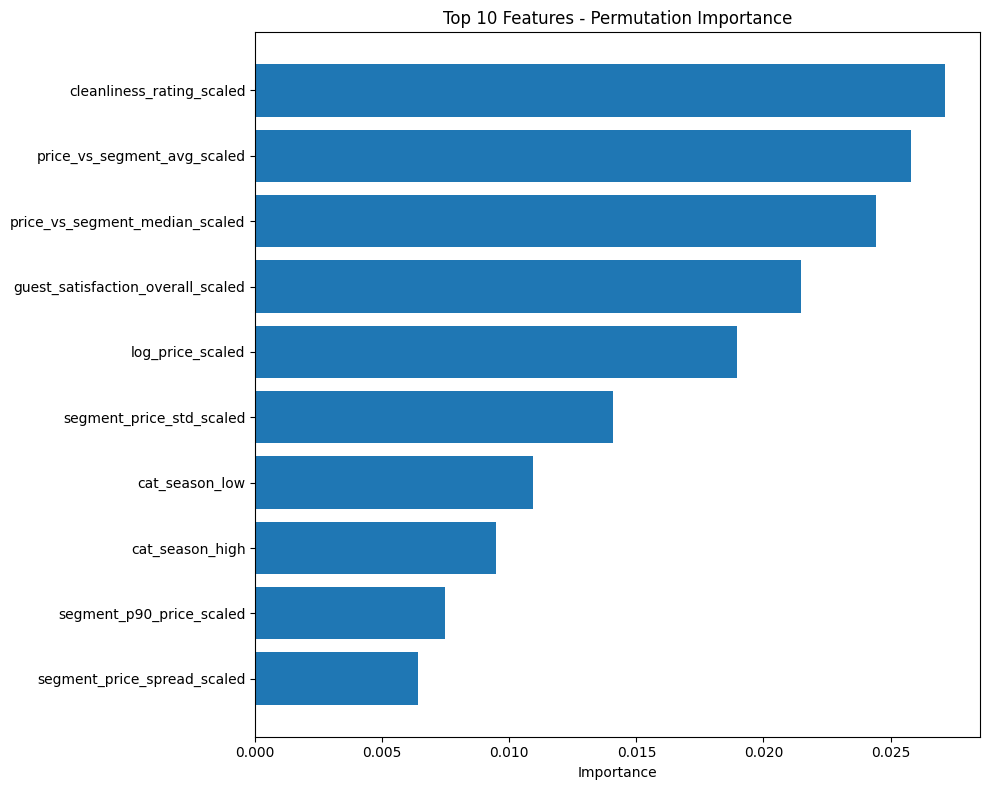

In [14]:
# PyTorch Model Feature Importance

"""
Feature Importance for PyTorch Neural Networks
"""

import torch
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ============================================================================
# METHOD 1: PERMUTATION IMPORTANCE (Most Reliable)
# ============================================================================
def get_permutation_importance(model, X_val, y_val, feature_cols, n_repeats=10):
    """
    Calculate feature importance by measuring performance drop
    when each feature is randomly shuffled.
    """
    model.eval()
    
    # Baseline performance with clipping
    with torch.no_grad():
        baseline_pred = model(X_val)
        baseline_pred = torch.clamp(baseline_pred, -10, 10)  # ADD THIS
        baseline_rmse = torch.sqrt(
            torch.mean((torch.expm1(baseline_pred) - torch.expm1(y_val)) ** 2)
        ).item()
    
    importances = []
    
    print("Calculating permutation importance...")
    for i, feature in enumerate(feature_cols):
        importance_scores = []
        
        for _ in range(n_repeats):
            # Create copy and shuffle feature i
            X_permuted = X_val.clone()
            shuffle_idx = torch.randperm(X_val.size(0))
            X_permuted[:, i] = X_permuted[shuffle_idx, i]
            
            # Calculate performance drop with clipping
            with torch.no_grad():
                perm_pred = model(X_permuted)
                perm_pred = torch.clamp(perm_pred, -10, 10)  # ADD THIS
                
                # Check for invalid predictions
                if torch.isnan(perm_pred).any() or torch.isinf(perm_pred).any():
                    importance_scores.append(0)  # Skip invalid
                    continue
                
                perm_rmse = torch.sqrt(
                    torch.mean((torch.expm1(perm_pred) - torch.expm1(y_val)) ** 2)
                ).item()
            
            # Importance = increase in error
            importance = perm_rmse - baseline_rmse
            
            # Handle overflow/invalid values
            if np.isnan(importance) or np.isinf(importance):
                importance_scores.append(0)
            else:
                importance_scores.append(max(0, importance))  # Only positive importance
        
        avg_importance = np.mean(importance_scores)
        importances.append(avg_importance)
        
        if (i + 1) % 10 == 0:
            print(f"  Processed {i+1}/{len(feature_cols)} features")
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    return importance_df

# ============================================================================
# METHOD 2: GRADIENT-BASED IMPORTANCE (Fast Alternative)
# ============================================================================
def get_gradient_importance(model, X_val, y_val, feature_cols):
    """
    Calculate feature importance based on gradients.
    Measures how much each feature affects the loss.
    """
    model.eval()
    
    # Enable gradient tracking for input
    X_val_grad = X_val.clone().requires_grad_(True)
    
    # Forward pass
    pred = model(X_val_grad)
    loss = torch.mean((pred - y_val) ** 2)
    
    # Backward pass to get gradients
    loss.backward()
    
    # Calculate importance as mean absolute gradient
    gradient_importance = torch.mean(torch.abs(X_val_grad.grad), dim=0).detach().numpy()
    
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': gradient_importance
    }).sort_values('importance', ascending=False)
    
    return importance_df

# ============================================================================
# METHOD 3: FIRST LAYER WEIGHTS (Approximation for Linear Relationships)
# ============================================================================
def get_weight_importance(model, feature_cols):
    """
    Analyze first layer weights as proxy for feature importance.
    Works best for relatively simple patterns.
    """
    # Get first layer weights
    first_layer = list(model.parameters())[0]  # First Linear layer weights
    weights = first_layer.detach().numpy()
    
    # Calculate mean absolute weight for each input feature
    weight_importance = np.mean(np.abs(weights), axis=0)
    
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': weight_importance
    }).sort_values('importance', ascending=False)
    
    return importance_df

# ============================================================================
# VISUALIZATION
# ============================================================================
def plot_feature_importance(importance_df, top_n=10, title="Feature Importance"):
    """
    Plot top N most important features.
    """
    top_features = importance_df.head(top_n)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# ============================================================================
# FEATURE IMPORTANCE - OPTIMIZED FOR BIG DATA WITH SCALED FEATURES
# ============================================================================

# Sample for feature importance (avoid loading full test set into pandas)
print("Sampling data for feature importance calculation...")
sample_fraction = min(1.0, 10000 / test_df.count())  # Max 10k rows
test_sample = test_df.sample(fraction=sample_fraction, seed=42)

print(f"Using {test_sample.count():,} samples for feature importance")

# Convert sample to pandas
test_pd = test_sample.toPandas().fillna(0)

# Use the scaled features (all_features = scaled_numeric + binary)
X_val = torch.from_numpy(test_pd[all_features].values.astype(np.float32))
y_val = torch.from_numpy(np.log1p(test_pd[target_col].values.astype(np.float32))).view(-1, 1)

print(f"Feature importance using {len(all_features)} scaled features")

# Method 1: Permutation Importance (RECOMMENDED - most accurate)
print("\nCalculating permutation importance...")
perm_importance = get_permutation_importance(model, X_val, y_val, all_features, n_repeats=10)
print("\nTop 10 Features (Permutation Importance):")
print(perm_importance.head(10))

# Method 2: Gradient Importance (fast, good approximation)
print("\nCalculating gradient importance...")
grad_importance = get_gradient_importance(model, X_val, y_val, all_features)
print("\nTop 10 Features (Gradient Importance):")
print(grad_importance.head(10))

# Method 3: Weight Analysis (quick but less accurate)
print("\nCalculating weight-based importance...")
weight_importance = get_weight_importance(model, all_features)
print("\nTop 10 Features (Weight Analysis):")
print(weight_importance.head(10))

# Save feature importance results
outputs_dir = project_root / 'outputs'
perm_importance.to_csv(outputs_dir / 'pytorch_feature_importance_permutation.csv', index=False)
grad_importance.to_csv(outputs_dir / 'pytorch_feature_importance_gradient.csv', index=False)
weight_importance.to_csv(outputs_dir / 'pytorch_feature_importance_weights.csv', index=False)

print(f"\nSaved feature importance to outputs/")
print("  • pytorch_feature_importance_permutation.csv")
print("  • pytorch_feature_importance_gradient.csv")
print("  • pytorch_feature_importance_weights.csv")

# Visualize
plot_feature_importance(perm_importance, top_n=10, 
                       title="Top 10 Features - Permutation Importance")


### TensorFlow Keras Neural Network

In [15]:
"""
Production TensorFlow/Keras Training with PySpark - Big Data Ready
Updated to use scaled features
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import warnings

# Suppress warnings for clean output
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

# Force CPU for compatibility
tf.config.set_visible_devices([], 'GPU')
print(f"Using device: CPU\n")
print(f"TensorFlow version: {tf.__version__}\n")

# ============================================================================
# 1. BUILD KERAS MODEL WITH GRADIENT CLIPPING
# ============================================================================
def build_mlp_regressor(input_dim):
    """
    Creates a robust MLP regression model with output constraints.

    This MLP architecture uses a progressive compression design (input_dim → 128 → 64 → 32 → 1)
    to efficiently capture hierarchical feature representations while minimizing overfitting.
    The initial expansion to 128 neurons with He normal initialization enables robust learning 
    of complex input patterns, followed by controlled reduction to distill essential information 
    for the regression output. ReLU activations provide non-linearity for expressive modeling, 
    and strategically applied dropout (0.3 early, 0.2 late) regularizes training without excessive 
    capacity loss—ideal for stable, generalizable performance on tabular regression tasks.
    
    Note on Keras parameters:
    - `ReLU` (Rectified Linear Unit) is a simple activation function that outputs max(0, x)—zeros negative values 
        while passing positive ones unchanged, adding non-linearity for learning complex patterns efficiently.
    - `kernel_initializer` is a parameter in Keras/TensorFlow that controls how the initial weights 
        (parameters) of a neural network layer are set before training begins.
    - `He_normal` (He initialization) gives better starting points for ReLU activations, enabling faster, 
        more stable training. Poor initialization with ReLU can cause issues like vanishing gradients 
        (signals too weak across layers) or dying ReLUs (neurons stuck at zero output).  
    - TensorFlow/Keras Dense defaults to Glorot uniform, which works better for sigmoid/tanh but can cause 
        vanishing gradients or dying ReLUs in ReLU networks—hence explicitly setting he_normal.  
    """
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),             # Input layer: defines input shape for dynamic feature processing
        layers.Dense(128, activation='relu', 
                     kernel_initializer='he_normal'), # Initial expansion layer: increases dimensionality with He normal init to capture complex patterns from input features
        layers.Dropout(0.3),                          # Regularization: prevents overfitting by randomly dropping 30% of neurons during training
        layers.Dense(64, activation='relu', 
                     kernel_initializer='he_normal'), # Hidden layer: progressively reduces parameters while retaining key representations with stable initialization
        layers.Dropout(0.3),                          # Regularization: continues overfitting prevention with same dropout rate
        layers.Dense(32, activation='relu', 
                     kernel_initializer='he_normal'), # Final hidden layer: further compression toward output dimensionality with He normal init
        layers.Dropout(0.2),                          # Lighter regularization: reduced dropout as we're closer to output
        layers.Dense(1)                               # Output layer: single neuron for regression task (predicting continuous value)
    ])
    
    return model

# ============================================================================
# 2. TRAINING FUNCTION - STABLE FOR BIG DATA
# ============================================================================
def train_keras_on_pyspark(train_df, test_df, feature_cols, target_col,
                           max_epochs=200, patience=15, batch_size=512,
                           num_chunks=5, target_is_log=False):
    """
    Trains TensorFlow/Keras model on PySpark DataFrames with chunked processing.
    Includes stability improvements to prevent overflow and NaN issues.
    Returns model and metrics dictionary.
    """
    
    print(f"Training samples: {train_df.count():,}")
    print(f"Validation samples: {test_df.count():,}")
    print(f"Features: {len(feature_cols)}\n")
    
    # Convert validation set
    print("Converting validation data...")
    test_pd = test_df.toPandas()
    test_pd = test_pd.fillna(0)
    
    X_val = test_pd[feature_cols].values.astype(np.float32)
    y_val_raw = test_pd[target_col].values.astype(np.float32)
    
    # Apply log transform if needed
    if not target_is_log:
        y_val_raw = np.log1p(y_val_raw)
        print("Applied log1p transform to target")
    
    y_val = y_val_raw.reshape(-1, 1)
    
    print(f"Validation target range: [{y_val.min():.2f}, {y_val.max():.2f}]")
    
    # Initialize model
    num_features = len(feature_cols)
    model = build_mlp_regressor(num_features)
    
    # Compile with gradient clipping for stability
    optimizer = keras.optimizers.Adam(
        learning_rate=1e-3,
        clipnorm=1.0  # Clip gradients to prevent explosion
    )
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    
    print("\nModel Architecture:")
    model.summary()
    
    # Learning rate reduction tracking
    lr_patience = 0
    lr_wait = 5
    best_val_loss = float('inf')
    
    best_rmse = float('inf')
    best_mae = float('inf')
    best_r2 = -float('inf')
    best_weights = None
    patience_counter = 0
    
    print(f"\n{'='*70}")
    print("Starting training...")
    print(f"{'='*70}\n")
    
    # Training loop
    for epoch in range(max_epochs):
        epoch_losses = []
        num_samples = 0
        
        # Split into chunks
        chunk_weights = [1.0 / num_chunks] * num_chunks
        train_chunks = train_df.randomSplit(chunk_weights, seed=42 + epoch)
        
        # Process each chunk
        for chunk_idx, chunk_df in enumerate(train_chunks):
            chunk_pd = chunk_df.toPandas()
            
            if len(chunk_pd) < 2:
                continue
            
            chunk_pd = chunk_pd.fillna(0)
            
            # Prepare data
            X_chunk = chunk_pd[feature_cols].values.astype(np.float32)
            y_chunk_raw = chunk_pd[target_col].values.astype(np.float32)
            
            if not target_is_log:
                y_chunk_raw = np.log1p(y_chunk_raw)
            
            y_chunk = y_chunk_raw.reshape(-1, 1)
            
            # Train on chunk in batches
            num_samples_chunk = len(X_chunk)
            indices = np.arange(num_samples_chunk)
            np.random.shuffle(indices)
            
            for i in range(0, num_samples_chunk - batch_size, batch_size):
                batch_indices = indices[i:i + batch_size]
                X_batch = X_chunk[batch_indices]
                y_batch = y_chunk[batch_indices]
                
                # Train on batch
                loss = model.train_on_batch(X_batch, y_batch)
                epoch_losses.append(loss)
                num_samples += len(X_batch)
        
        # Validation phase
        val_pred = model.predict(X_val, verbose=0)
        
        # Clip predictions to prevent overflow (critical for stability)
        val_pred = np.clip(val_pred, -10, 10)  # Reasonable range for log-space
        
        val_loss = np.mean((val_pred - y_val) ** 2)
        
        # Calculate metrics on ORIGINAL scale with safe inverse transform
        with np.errstate(over='ignore', invalid='ignore'):  # Suppress overflow warnings
            pred_original = np.expm1(val_pred)
            y_val_original = np.expm1(y_val)
            
            # Clip to reasonable range
            pred_original = np.clip(pred_original, 0, 1e6)
            y_val_original = np.clip(y_val_original, 0, 1e6)
            
            val_rmse = np.sqrt(np.mean((pred_original - y_val_original) ** 2))
            val_mae = np.mean(np.abs(pred_original - y_val_original))
            
            # Calculate R²
            ss_res = np.sum((y_val_original - pred_original) ** 2)
            ss_tot = np.sum((y_val_original - np.mean(y_val_original)) ** 2)
            val_r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        
        # Learning rate reduction (manual implementation)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            lr_patience = 0
        else:
            lr_patience += 1
            if lr_patience >= lr_wait:
                old_lr = float(model.optimizer.learning_rate.numpy())
                new_lr = old_lr * 0.5
                model.optimizer.learning_rate.assign(new_lr)
                print(f"    → Reducing learning rate to {new_lr:.2e}")
                lr_patience = 0
        
        avg_train_loss = np.mean(epoch_losses) if epoch_losses else 0
        
        # Print every 5 epochs or when improving
        if epoch % 5 == 0 or val_rmse < best_rmse:
            print(f"Epoch {epoch+1:3d}/{max_epochs} | "
                  f"Train MSE: {avg_train_loss:.4f} | "
                  f"Val RMSE: {val_rmse:.2f} | "
                  f"Val MAE: {val_mae:.2f} | "
                  f"Val R²: {val_r2:.4f}")
        
        # Early stopping
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_mae = val_mae
            best_r2 = val_r2
            best_weights = model.get_weights()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break
    
    # Restore best weights
    if best_weights:
        model.set_weights(best_weights)
    
    print(f"\n{'='*70}")
    print(f"TRAINING COMPLETE")
    print(f"Best Validation RMSE: {best_rmse:.2f} bookings")
    print(f"Best Validation MAE:  {best_mae:.2f} bookings")
    print(f"Best Validation R²:   {best_r2:.4f}")
    print(f"{'='*70}\n")
    
    # Return metrics dictionary
    metrics = {
        'model': 'TensorFlow_Keras_MLP',
        'rmse': float(best_rmse),
        'mae': float(best_mae),
        'r2': float(best_r2)
    }
    
    return model, metrics

# ============================================================================
# 3. CONFIGURE AND RUN
# ============================================================================
target_col = 'occupancy_rate'
label_col = 'label'

# Use scaled features (same as PyTorch)
feature_cols = all_features  # Uses scaled numeric + binary features

print(f"Target column: {target_col}")
print(f"Feature columns: {feature_cols[:5]}... ({len(feature_cols)} total)\n")

# Train model
model, metrics = train_keras_on_pyspark(
    train_df=train_df,
    test_df=test_df,
    feature_cols=feature_cols,  # ← Uses scaled features
    target_col=target_col,
    max_epochs=200,
    patience=15,
    batch_size=512,
    num_chunks=5,
    target_is_log=False
)

print(f"Final TensorFlow/Keras Model RMSE: {metrics['rmse']:.2f} bookings")
print(f"Final TensorFlow/Keras Model MAE: {metrics['mae']:.2f} bookings")
print(f"Final TensorFlow/Keras Model R²: {metrics['r2']:.4f}")

# ============================================================================
# 4. UPDATE SUMMARY DATAFRAME
# ============================================================================
models_summary_info = pd.concat([
    models_summary_info, 
    pd.DataFrame([metrics])
], ignore_index=True)

print("\nUpdated models_summary_info:")
print(models_summary_info)

# ============================================================================
# 5. SAVE MODEL (Production-ready)
# ============================================================================
model.save('../models/airbnb_keras_model.keras')
print("\nModel saved to '../models/airbnb_keras_model.keras'")

# Save metadata
import json

metadata = {
    'model_type': 'TensorFlow_Keras_MLP',
    'framework_version': tf.__version__,
    'model_architecture': {
        'input_dim': len(feature_cols),
        'layers': [128, 64, 32, 1],
        'activation': 'relu',
        'dropout_rates': [0.3, 0.3, 0.2],
        'kernel_initializer': 'he_normal',
        'output_activation': None
    },
    'feature_cols': feature_cols,
    'target_col': target_col,
    'num_features': len(feature_cols),
    'metrics': metrics,
    'hyperparameters': {
        'batch_size': 512,
        'max_epochs': 200,
        'patience': 15,
        'num_chunks': 5,
        'learning_rate': 1e-3,
        'optimizer': 'Adam',
        'clipnorm': 1.0,
        'lr_reduction_factor': 0.5,
        'lr_reduction_patience': 5
    },
    'preprocessing': {
        'numeric_features_scaled': True,  # NEW: indicates scaling was applied
        'target_transform': 'log1p',
        'missing_value_strategy': 'fill_zero',
        'prediction_clipping': [-10, 10],
        'output_clipping': [0, 1e6]
    },
    'training_info': {
        'train_samples': train_df.count(),
        'val_samples': test_df.count(),
        'target_is_log': False,
        'device': 'CPU'
    }
}

with open('../models/airbnb_keras_model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("Metadata saved to '../models/airbnb_keras_model_metadata.json'")


Using device: CPU

TensorFlow version: 2.19.1

Target column: occupancy_rate
Feature columns: ['listing_price_scaled', 'person_capacity_scaled', 'cleanliness_rating_scaled', 'guest_satisfaction_overall_scaled', 'bedrooms_scaled']... (48 total)

Training samples: 244,392
Validation samples: 60,860
Features: 48

Converting validation data...
Applied log1p transform to target
Validation target range: [0.05, 0.68]

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,641 (65.00 KB)

 Trainable params: 16,641 (65.00 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...

Epoch   1/200 | Train MSE: 0.3834 | Val RMSE: 0.20 | Val MAE: 0.16 | Val R²: 0.2790
Epoch   2/200 | Train MSE: 0.1177 | Val RMSE: 0.15 | Val MAE: 0.12 | Val R²: 0.5848
Epoch   3/200 | Train MSE: 0.0852 | Val RMSE: 0.13 | Val MAE: 0.10 | Val R²: 0.6819
Epoch   4/200 | Train MSE: 0.0699 | Val RMSE: 0.12 | Val MAE: 0.10 | Val R²: 0.7285
Epoch   5/200 | Train MSE: 0.0609 | Val RMSE: 0.12 | Val MAE: 0.09 | Val R²: 0.7533
Epoch   6/200 | Train MSE: 0.0550 | Val RMSE: 0.12 | Val MAE: 0.09 | Val R²: 0.7507
Epoch   7/200 | Train MSE: 0.0508 | Val RMSE: 0.11 | Val MAE: 0.09 | Val R²: 0.7692
Epoch   8/200 | Train MSE: 0.0476 | Val RMSE: 0.11 | Val MAE: 0.09 | Val R²: 0.7738
Epoch  10/200 | Train MSE: 0.0431 | Val RMSE: 0.10 | Val MAE: 0.08 | Val R²: 0.8041
Epoch  11/200 | Train MSE: 0.0414 | Val RMSE: 0.11 | Val MAE: 0.09 | Val R²: 0.7934
    → Reducing learning rate to 5.00e-04
Epoch  16/200 | Train MSE: 0.0362 | Val RMSE: 0.10 | Val MAE: 0.08 | Val R²: 0.8082
Epoch  18/20

Sampling data for Keras feature importance calculation...
Using 10,013 samples for feature importance
Feature importance using 48 scaled features

Calculating permutation importance...
Calculating permutation importance...
  Processed 10/48 features
  Processed 20/48 features
  Processed 30/48 features
  Processed 40/48 features

Top 10 Features (Permutation Importance):
                              feature  importance
20     price_vs_segment_median_scaled    0.024126
2           cleanliness_rating_scaled    0.020640
21        price_vs_segment_avg_scaled    0.018915
3   guest_satisfaction_overall_scaled    0.016044
18           segment_price_std_scaled    0.008855
16           segment_p90_price_scaled    0.007071
46                     cat_season_low    0.006707
1              person_capacity_scaled    0.005854
19        segment_price_spread_scaled    0.005624
14           segment_avg_price_scaled    0.005320

Calculating gradient importance...

Top 10 Features (Gradient Importance):


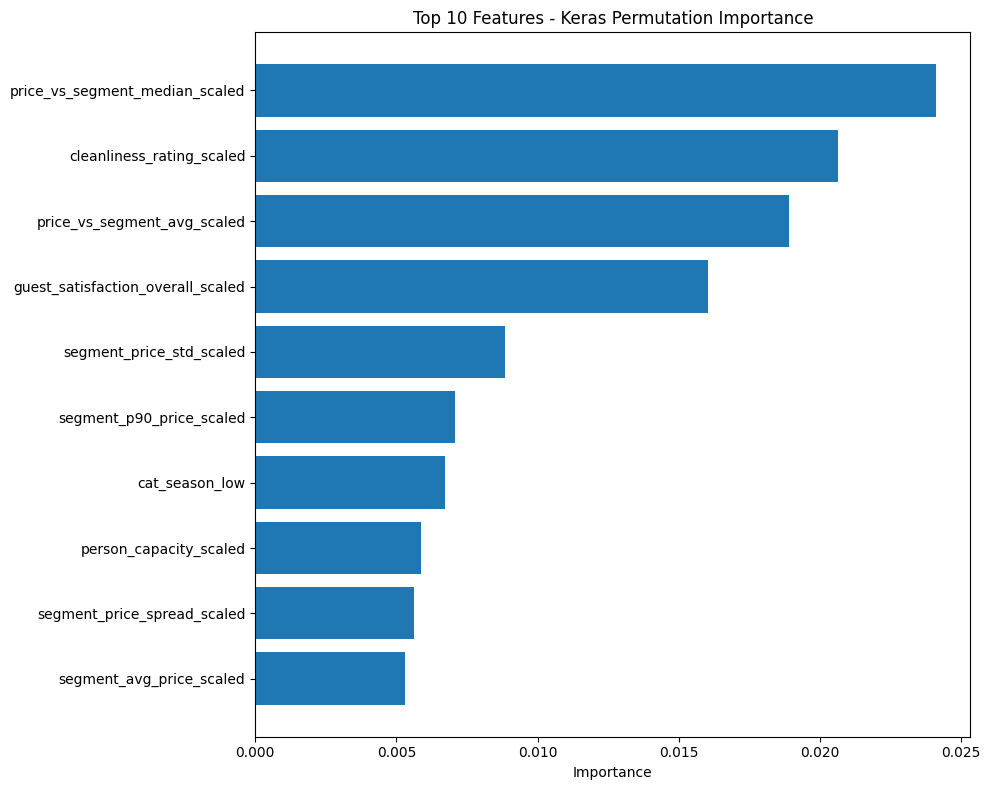


Saved Keras feature importance to outputs/
  • keras_feature_importance_permutation.csv
  • keras_feature_importance_gradient.csv
  • keras_feature_importance_weights.csv


In [16]:
"""
Feature Importance for TensorFlow/Keras Neural Networks
"""

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================================
# METHOD 1: PERMUTATION IMPORTANCE (Most Reliable)
# ============================================================================
def get_permutation_importance_keras(model, X_val, y_val, feature_cols, n_repeats=10):
    """
    Calculate feature importance by measuring performance drop
    when each feature is randomly shuffled.
    """
    
    # Baseline performance
    baseline_pred = model.predict(X_val, verbose=0)
    baseline_pred = np.clip(baseline_pred, -10, 10)
    
    baseline_rmse = np.sqrt(
        np.mean((np.expm1(baseline_pred) - np.expm1(y_val)) ** 2)
    )
    
    importances = []
    
    print("Calculating permutation importance...")
    for i, feature in enumerate(feature_cols):
        importance_scores = []
        
        for _ in range(n_repeats):
            # Create copy and shuffle feature i
            X_permuted = X_val.copy()
            np.random.shuffle(X_permuted[:, i])
            
            # Calculate performance drop
            perm_pred = model.predict(X_permuted, verbose=0)
            perm_pred = np.clip(perm_pred, -10, 10)
            
            perm_rmse = np.sqrt(
                np.mean((np.expm1(perm_pred) - np.expm1(y_val)) ** 2)
            )
            
            # Importance = increase in error
            importance = perm_rmse - baseline_rmse
            importance_scores.append(importance)
        
        avg_importance = np.mean(importance_scores)
        importances.append(avg_importance)
        
        if (i + 1) % 10 == 0:
            print(f"  Processed {i+1}/{len(feature_cols)} features")
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    return importance_df

# ============================================================================
# METHOD 2: GRADIENT-BASED IMPORTANCE (Fast Alternative)
# ============================================================================
def get_gradient_importance_keras(model, X_val, y_val, feature_cols):
    """
    Calculate feature importance based on gradients.
    Measures how much each feature affects the loss.
    """
    
    # Convert to TensorFlow tensors
    X_val_tf = tf.Variable(X_val, dtype=tf.float32)
    y_val_tf = tf.constant(y_val, dtype=tf.float32)
    
    # Calculate gradients
    with tf.GradientTape() as tape:
        tape.watch(X_val_tf)
        pred = model(X_val_tf, training=False)
        loss = tf.reduce_mean((pred - y_val_tf) ** 2)
    
    # Get gradients with respect to input
    gradients = tape.gradient(loss, X_val_tf)
    
    # Calculate importance as mean absolute gradient
    gradient_importance = tf.reduce_mean(tf.abs(gradients), axis=0).numpy()
    
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': gradient_importance
    }).sort_values('importance', ascending=False)
    
    return importance_df

# ============================================================================
# METHOD 3: FIRST LAYER WEIGHTS (Approximation for Linear Relationships)
# ============================================================================
def get_weight_importance_keras(model, feature_cols):
    """
    Analyze first layer weights as proxy for feature importance.
    Works best for relatively simple patterns.
    """
    # Get first layer weights (skip Input layer, get first Dense layer)
    first_dense_layer = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            first_dense_layer = layer
            break
    
    if first_dense_layer is None:
        raise ValueError("No Dense layer found in model")
    
    # Get weights (weights[0] is the kernel, weights[1] is bias)
    weights = first_dense_layer.get_weights()[0]  # Shape: (input_dim, units)
    
    # Calculate mean absolute weight for each input feature
    weight_importance = np.mean(np.abs(weights), axis=1)
    
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': weight_importance
    }).sort_values('importance', ascending=False)
    
    return importance_df

# ============================================================================
# VISUALIZATION
# ============================================================================
def plot_feature_importance(importance_df, top_n=10, title="Feature Importance"):
    """
    Plot top N most important features.
    """
    top_features = importance_df.head(top_n)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# ============================================================================
# TENSORFLOW/KERAS FEATURE IMPORTANCE - WITH SCALED FEATURES
# ============================================================================

# Sample for feature importance (avoid loading full test set into pandas)
print("Sampling data for Keras feature importance calculation...")
sample_fraction = min(1.0, 10000 / test_df.count())  # Max 10k rows
test_sample = test_df.sample(fraction=sample_fraction, seed=42)

print(f"Using {test_sample.count():,} samples for feature importance")

# Convert sample to pandas
test_pd = test_sample.toPandas().fillna(0)

# Use the scaled features (all_features = scaled_numeric + binary)
X_val = test_pd[all_features].values.astype(np.float32)
y_val = np.log1p(test_pd[target_col].values.astype(np.float32)).reshape(-1, 1)

print(f"Feature importance using {len(all_features)} scaled features")

# Method 1: Permutation Importance (RECOMMENDED - most accurate)
print("\nCalculating permutation importance...")
perm_importance = get_permutation_importance_keras(model, X_val, y_val, all_features, n_repeats=10)
print("\nTop 10 Features (Permutation Importance):")
print(perm_importance.head(10))

# Method 2: Gradient Importance (fast, good approximation)
print("\nCalculating gradient importance...")
grad_importance = get_gradient_importance_keras(model, X_val, y_val, all_features)
print("\nTop 10 Features (Gradient Importance):")
print(grad_importance.head(10))

# Method 3: Weight Analysis (quick but less accurate)
print("\nCalculating weight-based importance...")
weight_importance = get_weight_importance_keras(model, all_features)
print("\nTop 10 Features (Weight Analysis):")
print(weight_importance.head(10))

# Visualize
plot_feature_importance(perm_importance, top_n=10, 
                       title="Top 10 Features - Keras Permutation Importance")

# Save feature importance results
outputs_dir = project_root / 'outputs'
perm_importance.to_csv(outputs_dir / 'keras_feature_importance_permutation.csv', index=False)
grad_importance.to_csv(outputs_dir / 'keras_feature_importance_gradient.csv', index=False)
weight_importance.to_csv(outputs_dir / 'keras_feature_importance_weights.csv', index=False)

print(f"\nSaved Keras feature importance to outputs/")
print("  • keras_feature_importance_permutation.csv")
print("  • keras_feature_importance_gradient.csv")
print("  • keras_feature_importance_weights.csv")

## Model Summary

In [17]:
import json

# Show final summary

models_summary_info.sort_values('rmse', inplace=True, ascending=True, ignore_index=True)

print("Models summary:")
display(models_summary_info)

# Save as JSON
out_json = outputs_dir / 'model_results.json'
out_json.parent.mkdir(parents=True, exist_ok=True)
with open(out_json, 'w', encoding='utf-8') as f:
    json.dump(models_summary_info.to_dict(orient='records'), f, indent=2)

print(f"Saved model results to: outputs\model_results.json")


Models summary:


,model,rmse,mae,r2
0,GBTRegressor,0.078616,0.059908,0.885005
1,PyTorch_MLP,0.081797,0.064411,0.875513
2,LinearRegression,0.088699,0.069466,0.853617
3,RandomForest,0.089537,0.070906,0.850838
4,TensorFlow_Keras_MLP,0.099718,0.081121,0.814988


Saved model results to: outputs\model_results.json
